In [274]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [275]:
df = pd.read_csv('./data/True.csv')
df.head()


In [277]:
# parameters

# reduced corpus size due to hardware and time constraints
dtype = torch.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
corpus_size = 2000
epochs = 3000
learning_rate = 0.001


In [278]:
import re

# functions to clean data

# filter out first part containing CITY (news agency) and separator "-"

# to be replaced: “ ”

# search and replace regex
double_quotes = r'“|”'
single_quotes = r'’|‘'
backslashes = r'\\'
multiple_whitespace = r'\t|\v|\f| '
double_quotes = re.compile(double_quotes)
single_quotes = re.compile(single_quotes)
backslashes = re.compile(backslashes)
multiple_whitespace = re.compile(multiple_whitespace)


def clean_data(row):
    txt = row[1].lower()
    txt = txt[txt.find('-')+1:].lstrip()
    txt = double_quotes.sub('"', txt)
    txt = txt.replace("’", "")
    txt = txt.replace("‘", "")
    txt = multiple_whitespace.sub(' ', txt)
    # remove everything before the first dash (news agency and city)
    txt = txt[txt.find('-')+1:]
    

    return txt


In [279]:
# function to tokenize the text

def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    # TODO: Implement Function
    token = dict()
    token['.'] = ' <PERIOD> '
    token[','] = ' <COMMA> '
    token['"'] = ' <QUOTATION_MARK> '
    token[':'] = ' <COLON>'
    token[';'] = ' <SEMICOLON> '
    token['!'] = ' <EXCLAIMATION_MARK> '
    token['?'] = ' <QUESTION_MARK> '
    token['('] = ' <LEFT_PAREN> '
    token[')'] = ' <RIGHT_PAREN> '
    token['-'] = ' <QUESTION_MARK> '
    token['\n'] = ' <NEW_LINE> '
    return token




In [280]:
def pad_to_max(tokenized, max):
    padding_length = max - len(tokenized)
    if padding_length == 0:
        return tokenized
    padding = ['<pad>' for i in range(padding_length)]
    tokenized.extend(padding)
    return tokenized

In [281]:
df = df[:corpus_size]
df = df.astype({'text': 'string'})

df['text'] = df.apply(clean_data, axis=1)
print(df['text'][0])
articles = df['text'].values.tolist()

longest_article = 0

token_dict = token_lookup()

tokenized_articles = []

for article in articles:
    for key, token in token_dict.items():
        article = article.replace(key, token)
    article = article.lower()
    article = article.split()
    if len(article) > longest_article:
        longest_article = len(article)
    tokenized_articles.append(article)
# for key, token in token_dict.items():
#     articles[0] = article[0].replace(key, token)

print(f'longest article contains {longest_article} tokens')


unique_tokens = set()

for tokens in tokenized_articles:
    tokens = pad_to_max(tokens, longest_article)
    for token in tokens:
        unique_tokens.add(token)

unique_tokens = list(unique_tokens)

print(f'there are {len(unique_tokens)} unique tokens')

print(f'articles equal length: {len(tokenized_articles[0])==len(tokenized_articles[1])}')

articles = [' '.join(art) for art in tokenized_articles]

print(articles[0])
print(tokenized_articles[0])

defense "discretionary" spending on programs that support education, scientific research, infrastructure, public health and environmental protection. "the (trump) administration has already been willing to say: were going to increase non-defense discretionary spending ... by about 7 percent," meadows, chairman of the small but influential house freedom caucus, said on the program. "now, democrats are saying thats not enough, we need to give the government a pay raise of 10 to 11 percent. for a fiscal conservative, i dont see where the rationale is. ... eventually you run out of other peoples money," he said. meadows was among republicans who voted in late december for their partys debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. "its interesting to hear mark talk about fiscal responsibility," democratic u.s. representative joseph crowley said on cbs. crowley said the republic

In [ ]:
with open('./data/tokenized_articles.dat', 'wb'):
    pickle.dump(tokenized_articles)

with open('./data/unique_words_2k_articles.dat', 'wb'):
    pickle.dump(unique_tokens)


In [282]:
# wor2vec params

batch_size = 5
embedding_size = 2
voc_size = len(unique_tokens)


In [283]:
# Make skip gram of one size window

# all tokens in all articles
word_sequence = []
for tokenized_article in tokenized_articles:
    word_sequence.extend(tokenized_article)

word_dict = {w: i for i, w in enumerate(unique_tokens)}

window_size = 2

skip_grams = []

for i in range(1, len(word_sequence) - window_size):
    input = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - window_size]],
               word_dict[word_sequence[i + window_size]]]
    for w in context:
        skip_grams.append([input, w])


In [284]:
np.random.seed(172)


def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        # one-hot encoding of words
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # input
        random_labels.append(data[i][1])  # context word

    return random_inputs, random_labels


In [285]:
# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()

        # parameters between -1 and + 1
        # voc_size -> embedding_size Weight
        self.W = nn.Parameter(-2 * torch.rand(voc_size,
                              embedding_size) + 1).type(dtype).to(device)
        # embedding_size -> voc_size Weight
        self.V = nn.Parameter(-2 * torch.rand(embedding_size,
                              voc_size) + 1).type(dtype).to(device)

        self.params = nn.ParameterList([self.W, self.V])

    def forward(self, X):
        # hidden_layer : [batch_size, embedding_size]
        hidden_layer = torch.matmul(X, self.params[0])
        # output_layer : [batch_size, voc_size]
        output_layer = torch.matmul(hidden_layer, self.params[1])
        #return output_layer
        return output_layer

model = Word2Vec()
# Set the model in train mode
model.train()

# Softmax (for multi-class classification problems) is already included
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(params=model.params, lr=0.001)


In [286]:
# Training
from datetime import datetime
import time

print_freq = (epochs // 10) or 1
all_losses = []
avg_loss = 0

print(f'<{time.now()}> Training started, doing {epochs} epochs on {corpus_size} articles')

for epoch in range(epochs):
    input_batch, target_batch = random_batch(skip_grams, batch_size)

    # new_tensor(data, dtype=None, device=None, requires_grad=False)
    input_batch = torch.Tensor(input_batch).to(device)
    target_batch = torch.LongTensor(target_batch).to(device)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    avg_loss += loss.item()
    if (epoch + 1) % print_freq == 0 or epoch == 0:
        epoch_time = datetime.fromtimestamp(time.time())
        print('<', epoch_time, '> Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        all_losses.append(avg_loss / print_freq)
        avg_loss = 0

    loss.backward()
    optimizer.step()
time_done = datetime.fromtimestamp(time.time())
print('<', time_done, '> Epoch:', '%04d' %
      (epoch + 1), 'cost =', '{:.6f}'.format(loss))


< 2023-05-28 15:51:49.413437 > Epoch: 10000 cost = 5.551216


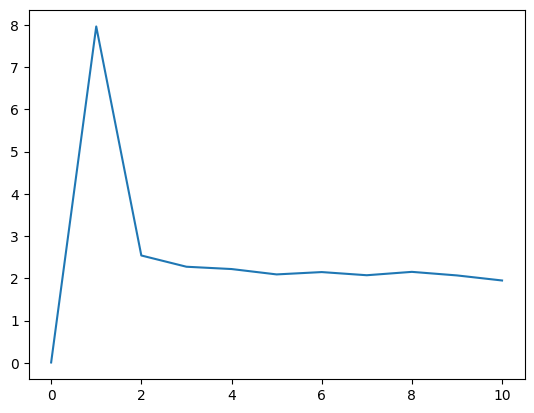

In [287]:
# plotting

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


# print(all_losses)
# matplotlib couldn't plot cuda tensors
# first copy to host memory by loss.cpu() - then detach and to np array
# losses_to_plot = [loss.cpu().detach().numpy() for loss in all_losses]
# this was f
# print(losses_to_plot)
plt.figure()
plt.plot(all_losses)


In [288]:
# Learned W
W, _ = model.parameters()
print(W.detach())


tensor([[ 0.0842, -0.9099],
        [ 0.0752,  0.6420],
        [ 0.2474, -0.8458],
        ...,
        [-0.9174,  0.0296],
        [ 0.3655, -0.7844],
        [-0.9243,  0.5034]], device='cuda:0')


In [289]:
# traiing done and saving the model for future additional training

file_path = f'./models/w2v_wsize_{window_size}_epocs_{epochs}.model'
torch.save(model.state_dict(), file_path)

end_time = datetime.fromtimestamp(time.time())
print(f'training finished at: {end_time}')


training finished at: 2023-05-28 15:51:49.627439


In [290]:
# saving dictionaries for both directions (word2vector and vector2word)

import pickle
W, _ = model.parameters()
W = W.detach()
w2v = {}
v2w = {}

for i, word in enumerate(unique_tokens):
    W, _ = model.parameters()
    W = W.detach()
    x, y = float(W[i][0]), float(W[i][1])
    w2v[word] = (x, y)
    v2w[(x, y)] = word

print(f'vocabulary size: {len(unique_tokens)}')

print(w2v['process'])

file_info = f'_{epochs}_ep_{len(articles)}_art_{len(unique_tokens)}_words'

with open(f'./models/w2v_{file_info}.dat', 'wb') as f_path:
    pickle.dump(w2v, f_path)

with open(f'./models/v2w{file_info}.dat', 'wb') as f_path:
    pickle.dump(v2w, f_path)


vocabulary size: 20448
(-0.3558875024318695, 0.9954854846000671)
